In [14]:
import tensorflow as tf
import tensorflow_datasets as tfds
from model import CycleGAN
from utils import plot_images_with_scores, infer_type
import logging
from configparser import ConfigParser
import wandb
import time
import atexit
import os
import matplotlib.pyplot as plt
from augment import get_data_augmentation
from tensorflow.keras import layers

IMG_RES=256

In [33]:
def get_data_augmentation():
    data_augmentation = tf.keras.Sequential([
        layers.Resizing(286,286),
        layers.RandomCrop(IMG_RES,IMG_RES),
        layers.RandomFlip(mode="horizontal"),
        layers.RandomContrast(0.2),
        layers.RandomBrighotness(0.2)
    ])
    return data_augmentation

In [2]:
import tensorflow as tf
class LinearDecaySchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    # Constant until decay_epoch, then linear to 0 until n_epoch
    def __init__(self, initial_learning_rate, decay_epoch, n_epoch):
        self.initial_learning_rate = initial_learning_rate
        self.decay_epoch = decay_epoch
        self.n_epoch = n_epoch
        self.decay = self.initial_learning_rate / (n_epoch - decay_epoch)

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        lr = self.initial_learning_rate - (step - self.decay_epoch) * self.decay
        return max(0, min(lr, self.initial_learning_rate))

2024-08-03 20:45:15.369289: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-03 20:45:15.382316: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-03 20:45:15.386041: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-03 20:45:15.397297: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-03 20:45:16.121164: W tensorflow/compiler/tf2

In [9]:
tf.keras.losses.BinaryCrossentropy()(tf.expand_dims(tf.convert_to_tensor(0)),tf.expand_dims(tf.convert_to_tensor(1)))

2024-08-03 20:46:31.798901: W tensorflow/core/framework/op_kernel.cc:1840] OP_REQUIRES failed at reduction_ops_common.h:147 : INVALID_ARGUMENT: Invalid reduction dimension (-1 for input with 0 dimension(s)
2024-08-03 20:46:31.798933: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Invalid reduction dimension (-1 for input with 0 dimension(s)


InvalidArgumentError: {{function_node __wrapped__Mean_device_/job:localhost/replica:0/task:0/device:GPU:0}} Invalid reduction dimension (-1 for input with 0 dimension(s) [Op:Mean] name: 

In [9]:
tf.ones_like(0.1)

I0000 00:00:1722688776.307770   71925 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1722688776.346482   71925 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1722688776.346709   71925 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1722688776.348769   71925 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [2]:
schedule = LinearDecaySchedule(0.0002, 50, 100)

In [8]:
schedule(101)

0

In [36]:

dataset = tfds.load('monet',batch_size=8)
setA, setB = dataset['photo'], dataset['monet']

def extract_image(X):
    return tf.cast(X['image'], dtype=tf.float32)

def scale(X):
    return X/127.5-1 # Scale to [-1,1]

setA = setA.map(extract_image)
setB = setB.map(extract_image)


# setA = setA.shuffle(500,seed=0,reshuffle_each_iteration=True)
# setB = setB.shuffle(500,seed=0,reshuffle_each_iteration=True)

data_augmentation = get_data_augmentation()

augmented_setA = setA.map(data_augmentation)
augmented_setB = setB.map(data_augmentation)

# setA = setA.map(scale)
# setB = setB.map(preprocess)
# augmented_setA = augmented_setA.map(preprocess)
# augmented_setB = augmented_setB.map(preprocess)



AttributeError: module 'keras.api._v2.keras.layers' has no attribute 'RandomBrighotness'

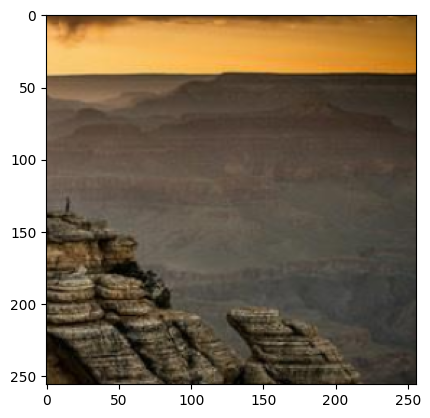

In [45]:
for batch in augmented_setA:
    img = batch[0,:,:,:]/256
    plt.imshow(img)
    break